In [138]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle
# import yfinance as yf
from datetime import datetime
from darts.metrics import rmse,mape
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RNNModel
from darts.utils.statistics import plot_acf
# df = yf.download("VCB.VN", start=datetime(2000,1,1), end=datetime.today())
# df = df.reset_index()
df = pd.read_csv('VCB.csv')
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-06-30,22898.183594,22898.183594,22898.183594,22898.183594,22898.183594,770543
1,2009-07-01,24043.093750,24043.093750,22707.365234,23089.001953,23089.001953,16372619
2,2009-07-02,22707.365234,22898.183594,21944.093750,22134.912109,22134.912109,3971498


In [2]:
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
3764,2024-08-08,87700.0,87700.0,87200.0,87300.0,87300.0,1213200
3765,2024-08-09,87400.0,88300.0,87400.0,87700.0,87700.0,1136700
3766,2024-08-12,88400.0,88400.0,87300.0,87800.0,87800.0,1102300


In [26]:
df.shape

(3767, 7)

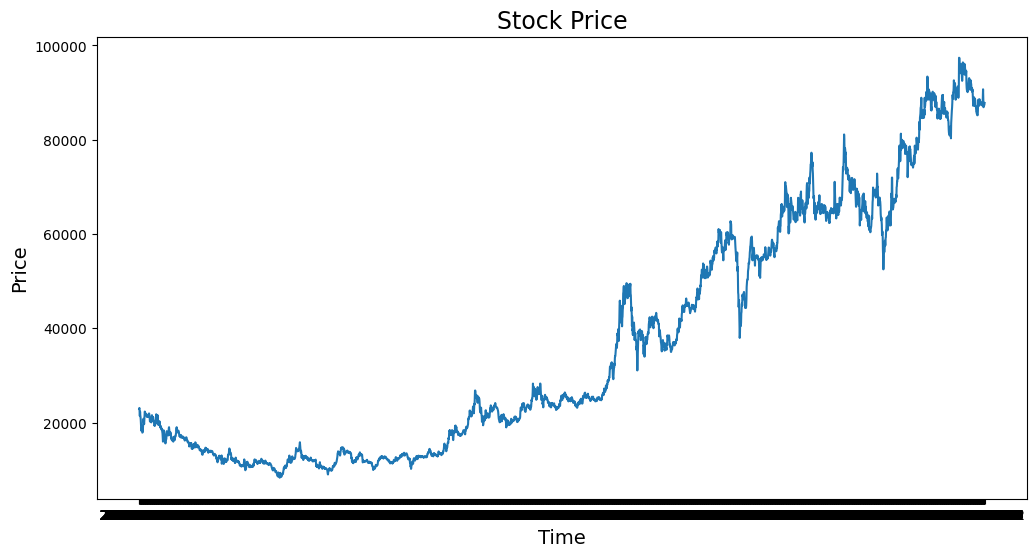

In [4]:
# Plot time series chart
plt.figure(figsize=(12,6))
plt.plot(df['Date'],df['Close'])
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.show()

# Data Preprocessing

Standardize the data

In [139]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df['scaled_close'] = standard_scaler.fit_transform(df['Close'].to_numpy().reshape(-1,1))


In [29]:
df = df.set_index('Date')

Split the data into train, test set (90/10)

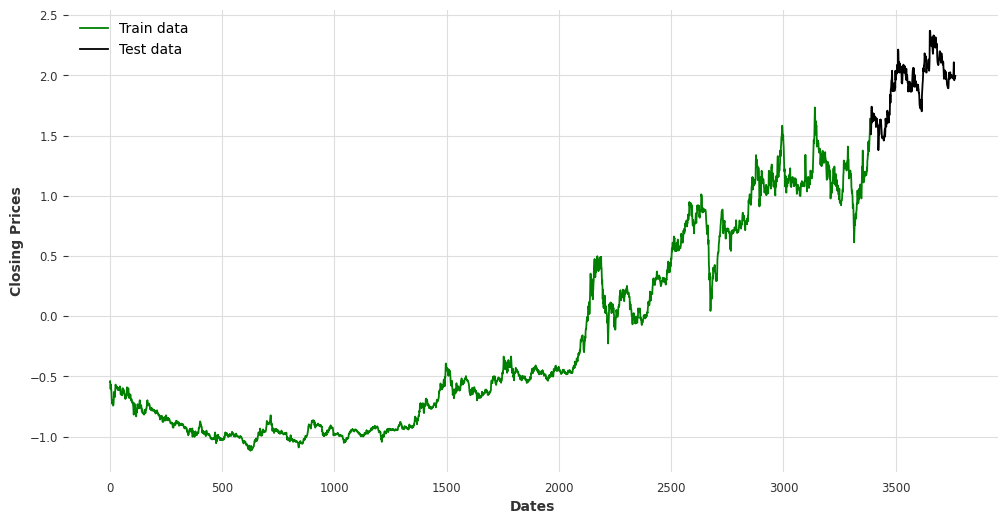

In [140]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, shuffle=False, test_size=0.1)

# plotting the data
plt.figure(figsize=(12,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['scaled_close'], 'green', label='Train data')
plt.plot(test_data['scaled_close'], label='Test data')
plt.legend()


Transform the time-series data into a matrix <br>
Each row is the historical data from day i to day i + window_size (by default, window_size = 60)

In [141]:
def prepare_data(data, window_size=60):
    X = []
    y = []
    for i in range(window_size,data.shape[0]):
        X.append(data.iloc[i-window_size:i])
        y.append(data.iloc[i])

    X = np.array(X)
    y = np.array(y)

    return X,y

X_train, y_train = prepare_data(data=train_data['scaled_close'], window_size=60)
X_test, y_test = prepare_data(data=test_data['scaled_close'], window_size=60)

In [142]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume,scaled_close
0,2009-06-30,22898.183594,22898.183594,22898.183594,22898.183594,22898.183594,770543,-0.545221
1,2009-07-01,24043.093750,24043.093750,22707.365234,23089.001953,23089.001953,16372619,-0.537753
2,2009-07-02,22707.365234,22898.183594,21944.093750,22134.912109,22134.912109,3971498,-0.575093
3,2009-07-03,21562.457031,21753.275391,21371.638672,21371.638672,21371.638672,2357526,-0.604965
4,2009-07-06,21371.638672,22325.730469,21371.638672,22325.730469,22325.730469,4118416,-0.567625
...,...,...,...,...,...,...,...,...
3385,2023-01-18,76206.601562,77053.343750,75698.562500,76206.601562,76206.601562,1044004,1.541118
3386,2023-01-19,75783.234375,81287.046875,74089.757812,78746.828125,78746.828125,2098400,1.640535
3387,2023-01-27,78746.828125,80101.609375,77476.710938,78746.828125,78746.828125,1872829,1.640535
3388,2023-01-30,77984.757812,78323.453125,76037.257812,76121.929688,76121.929688,1234145,1.537804


# Fitting model

## Ridge regression

In [143]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params_grid = {'alpha':list(range(1,100,10))}

ridge_model = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge_model, param_grid=params_grid)
grid_search_ridge.fit(X_train, y_train)



GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]})

In [144]:
pickle.dump(ridge_model, open('ridge.txt','wb'))

In [213]:
X_test.shape

(317, 60)

In [145]:
ridge_y_pred = grid_search_ridge.predict(X_test)
ridge_y_pred = standard_scaler.inverse_transform(ridge_y_pred.reshape(-1,1))

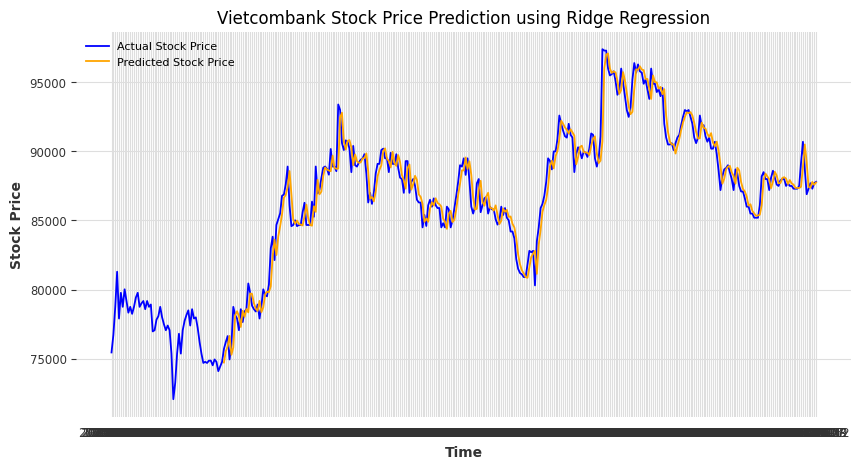

In [146]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
# plt.plot(validate_data['Date'], validate_data['Close'], color = 'green', label='Validation data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], ridge_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using Ridge Regression')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [147]:
from sklearn.metrics import mean_absolute_error,\
                            mean_squared_error,\
                            root_mean_squared_error,\
                            mean_absolute_percentage_error

y_true = test_data[60:]['Close'].values

# report performance
mse = mean_squared_error(y_true, ridge_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, ridge_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, ridge_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, ridge_y_pred)*100
print('MAPE: '+str(mape)+'%')

MSE: 1202692.8366580105
MAE: 798.8430057585148
RMSE: 1096.673532396041
MAPE: 0.9116424895650078%


forecast

In [159]:
y_test[-61:-1]

array([2.15531228, 2.12400258, 2.10834773, 2.12008887, 2.08877916,
       2.08877916, 2.10834773, 2.07312431, 2.02615975, 1.97136776,
       2.0105049 , 2.03007346, 2.03398718, 2.0418146 , 2.02224604,
       2.00267747, 1.97136776, 2.03007346, 2.01833232, 1.9831089 ,
       1.96745405, 1.96745405, 1.94788549, 1.92440321, 1.92440321,
       1.90483464, 1.90483464, 1.8930935 , 1.8930935 , 1.8930935 ,
       1.92831692, 2.0105049 , 2.02224604, 2.00267747, 2.00267747,
       1.97136776, 2.00659118, 2.02615975, 2.00659118, 1.98702262,
       1.9831089 , 1.99876376, 2.00267747, 2.00267747, 1.9831089 ,
       1.99093633, 1.9831089 , 1.9831089 , 1.97528148, 1.97528148,
       1.97528148, 1.9831089 , 2.04964203, 2.10834773, 2.03007346,
       1.95962662, 1.97528148, 1.99093633, 1.97528148, 1.99093633])

In [160]:
y_test[-1]

1.9948500435680452

In [255]:
future_lag = [i for i in range(365)]
future_label = []
that_year = []


In [237]:
y_test

array([1.52123449, 1.54111768, 1.55768736, 1.49140924, 1.53449005,
       1.64053486, 1.61733755, 1.6073958 , 1.57425674, 1.63390693,
       1.59745405, 1.62727899, 1.63390693, 1.70681268, 1.68030155,
       1.64384868, 1.63390693, 1.62727899, 1.64716249, 1.6073958 ,
       1.64384868, 1.6902433 , 1.67367362, 1.6703598 , 1.70349886,
       1.80622955, 1.83936861, 1.77309049, 1.87250768, 1.88907705,
       1.90564643, 1.95535487, 1.95866899, 1.98849393, 2.03820237,
       1.92884374, 1.86919356, 1.87250768, 1.88576324, 1.86919356,
       1.87250768, 1.87250768, 1.90896055, 1.93547168, 1.87250768,
       1.87250768, 1.87250768, 1.93878549, 1.89570499, 2.03820237,
       1.9619828 , 1.97192455, 2.00506361, 2.03488855, 2.03820237,
       2.03157474, 2.01500505, 2.0879108 , 2.03820237, 2.03820237,
       2.0249468 , 2.21401798, 2.19836313, 2.10443401, 2.08486545,
       2.11226144, 2.10834773, 2.08877916, 2.02224604, 2.09660659,
       2.0418146 , 2.03790089, 2.04964203, 2.05746945, 2.06138

In [256]:
# for a in range(4):
if len(future_label) < 60:
    that_year.append([b for b in y_test[-60 + len(future_label):]])
    # that_year.append([ i for i in future_label[-60:]])
print(that_year)
print('h')
# if len(that_year) <60:
#     that_year.append([b for b in y_test[-61 + len(that_year):]])
future_lag[0] = that_year
# that_year.clear()

# print(that_year)
print(future_lag)
print('\n')
print(grid_search_ridge.predict(future_lag[0]))
print('\n\n')

[[2.1240025786961945, 2.1083477259533887, 2.120088865510493, 2.088779160024881, 2.088779160024881, 2.1083477259533887, 2.073124307282075, 2.026159749053657, 1.971367764453836, 2.010504896310851, 2.0300734622393586, 2.03398717542506, 2.041814601796463, 2.0222460358679557, 2.002677469939448, 1.971367764453836, 2.0300734622393586, 2.0183323226822543, 1.9831089040109406, 1.9674540512681347, 1.9674540512681347, 1.947885485339627, 1.9244032062254182, 1.9244032062254182, 1.9048346402969105, 1.9048346402969105, 1.8930935007398062, 1.8930935007398062, 1.8930935007398062, 1.9283169194111196, 2.010504896310851, 2.0222460358679557, 2.002677469939448, 2.002677469939448, 1.971367764453836, 2.0065911831251495, 2.026159749053657, 2.0065911831251495, 1.987022617196642, 1.9831089040109406, 1.9987637567537466, 2.002677469939448, 2.002677469939448, 1.9831089040109406, 1.9909363303823435, 1.9831089040109406, 1.9831089040109406, 1.9752814776395375, 1.9752814776395375, 1.9752814776395375, 1.9831089040109406,

In [243]:
future_lag

[[[2.1240025786961945,
   2.1083477259533887,
   2.120088865510493,
   2.088779160024881,
   2.088779160024881,
   2.1083477259533887,
   2.073124307282075,
   2.026159749053657,
   1.971367764453836,
   2.010504896310851,
   2.0300734622393586,
   2.03398717542506,
   2.041814601796463,
   2.0222460358679557,
   2.002677469939448,
   1.971367764453836,
   2.0300734622393586,
   2.0183323226822543,
   1.9831089040109406,
   1.9674540512681347,
   1.9674540512681347,
   1.947885485339627,
   1.9244032062254182,
   1.9244032062254182,
   1.9048346402969105,
   1.9048346402969105,
   1.8930935007398062,
   1.8930935007398062,
   1.8930935007398062,
   1.9283169194111196,
   2.010504896310851,
   2.0222460358679557,
   2.002677469939448,
   2.002677469939448,
   1.971367764453836,
   2.0065911831251495,
   2.026159749053657,
   2.0065911831251495,
   1.987022617196642,
   1.9831089040109406,
   1.9987637567537466,
   2.002677469939448,
   2.002677469939448,
   1.9831089040109406,
   1.9909

In [220]:
len(future_lag[0][1])

60

In [225]:
len(that_year[3])

58

In [164]:
len(future_label)

366

In [171]:
str(pd.date_range(start='2024-08-13',end = '2025-08-14',freq = 'D'))

"DatetimeIndex(['2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',\n               '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-20',\n               '2024-08-21', '2024-08-22',\n               ...\n               '2025-08-05', '2025-08-06', '2025-08-07', '2025-08-08',\n               '2025-08-09', '2025-08-10', '2025-08-11', '2025-08-12',\n               '2025-08-13', '2025-08-14'],\n              dtype='datetime64[ns]', length=367, freq='D')"

In [167]:
test_data[60:]['Date']

3450    2023-04-26
3451    2023-04-27
3452    2023-04-28
3453    2023-05-04
3454    2023-05-05
           ...    
3762    2024-08-06
3763    2024-08-07
3764    2024-08-08
3765    2024-08-09
3766    2024-08-12
Name: Date, Length: 317, dtype: object

In [179]:
len(future_label)

366

In [175]:
unscaled_future_label = standard_scaler.inverse_transform(future_label)

In [187]:
len(unscaled_future_label[2])

317

ValueError: x and y must have same first dimension, but have shapes (366,) and (317,)

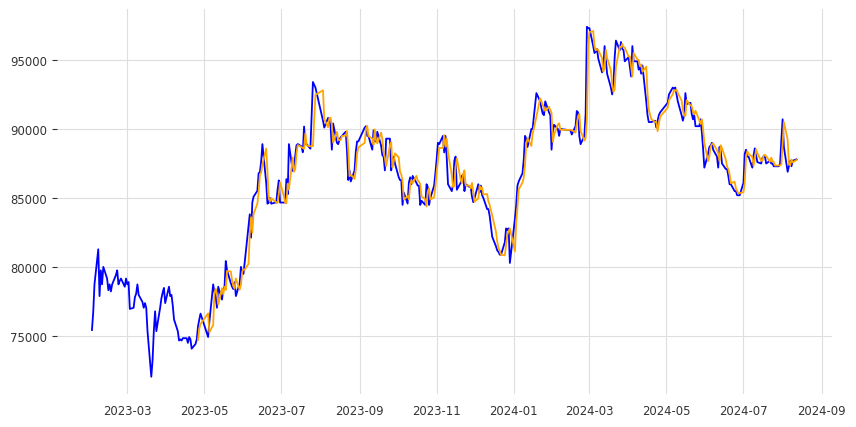

In [183]:
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
# plt.plot(validate_data['Date'], validate_data['Close'], color = 'green', label='Validation data')
plt.plot(pd.to_datetime(test_data['Date']), test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(pd.to_datetime(test_data[60:]['Date']), ridge_y_pred, color = 'orange',label='Predicted Stock Price')
plt.plot(pd.date_range(start='2024-08-13',end = '2025-08-13',freq = 'D'),unscaled_future_label[0],color = 'green',label = 'forecast')
plt.title('Vietcombank Stock Price Prediction using Ridge Regression')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [153]:
len(y_test)

317

## Support vector machine for regression

Hyperparameter tuning for SVM

In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameter_grid = {'kernel':['rbf', 'poly'],
                  'degree':list(range(1,6)),
                  'shrinking':[True, False],
                  }

svm_model = SVR()
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=parameter_grid, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)



GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'degree': [1, 2, 3, 4, 5], 'kernel': ['rbf', 'poly'],
                         'shrinking': [True, False]})

Save model using pickle module

In [15]:
pickle.dump(svm_model, open("svm_model.txt",'wb'))

In [16]:
svm_y_pred = grid_search_svm.predict(X_test)
svm_y_pred = standard_scaler.inverse_transform(svm_y_pred.reshape(-1,1))

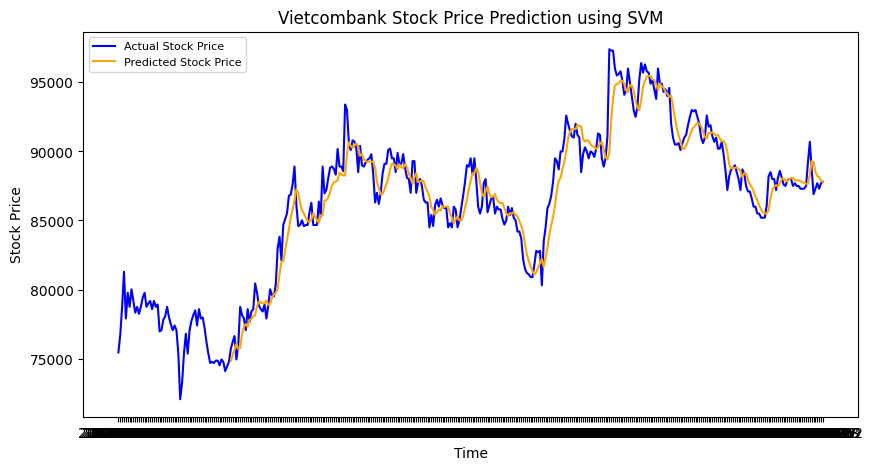

In [17]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
# plt.plot(validate_data['Date'], validate_data['Close'], color = 'green', label='Validation data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], svm_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using SVM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
y_true = test_data[60:]['Close'].values

# report performance
mse = mean_squared_error(y_true, svm_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, svm_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, svm_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, svm_y_pred)*100
print('MAPE: '+str(mape)+'%')

MSE: 1838047.6746560903
MAE: 1009.3872525085916
RMSE: 1355.7461689623506
MAPE: 1.1481148402872732%


## LSTM

In [32]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# LSTM layer 2
model.add(LSTM(units = 50))
model.add(Dense(40))
model.add(Dense(units = 1))
model.summary()

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         2,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,681 (127.66 KB)

 Trainable params: 32,681 (127.66 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 32)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - loss: 0.0713
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.0040
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 0.0033
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.0031
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0025
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - loss: 0.0022
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - loss: 0.0023
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - loss: 0.0017
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.0020
Epoch 10/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 0.0019


In [22]:
model.save('lstm_model.keras')

In [37]:
lstm_y_pred

array([[[-0.09188837],
        [-0.1194106 ],
        [-0.13953547],
        ...,
        [-0.17992061],
        [-0.17979679],
        [-0.17947757]],

       [[-0.09083623],
        [-0.11770897],
        [-0.13759081],
        ...,
        [-0.17979687],
        [-0.17947768],
        [-0.17873967]],

       [[-0.08916092],
        [-0.11552481],
        [-0.13934824],
        ...,
        [-0.17947778],
        [-0.17873973],
        [-0.17820773]],

       ...,

       [[-0.07805412],
        [-0.10601141],
        [-0.129846  ],
        ...,
        [-0.17638291],
        [-0.17670168],
        [-0.1764427 ]],

       [[-0.07867875],
        [-0.1060895 ],
        [-0.13025063],
        ...,
        [-0.17670184],
        [-0.17644283],
        [-0.17651322]],

       [[-0.07860056],
        [-0.10657217],
        [-0.13058917],
        ...,
        [-0.17644294],
        [-0.17651337],
        [-0.17619684]]], dtype=float32)

In [36]:
lstm_y_pred = model.predict(X_test)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step


In [43]:
lstm_y_pred.shape

(317, 1)

In [38]:
# predict on test data

lstm_y_pred = lstm_y_pred.reshape(317,1)
lstm_y_pred = standard_scaler.inverse_transform(lstm_y_pred)

,Open,High,Low,Close,Adj Close,Volume,scaled_close
Date,,,,,,,
2023-02-01,77900.085938,78323.453125,75444.539062,75444.539062,75444.539062,1342088,1.511293
2023-02-02,75021.171875,77900.085938,75021.171875,76714.648438,76714.648438,1217138,1.561001
2023-02-03,76460.625000,78746.828125,75444.539062,78746.828125,78746.828125,1102345,1.640535
2023-02-06,78408.125000,81541.070312,77476.710938,81287.046875,81287.046875,1688239,1.739952
2023-02-07,80694.328125,80863.671875,77900.085938,77900.085938,77900.085938,1735125,1.607396
...,...,...,...,...,...,...,...
2024-08-06,86900.000000,87700.000000,86700.000000,87300.000000,87300.000000,4273000,1.975281
2024-08-07,87400.000000,87700.000000,87000.000000,87700.000000,87700.000000,813000,1.990936
2024-08-08,87700.000000,87700.000000,87200.000000,87300.000000,87300.000000,1213200,1.975281


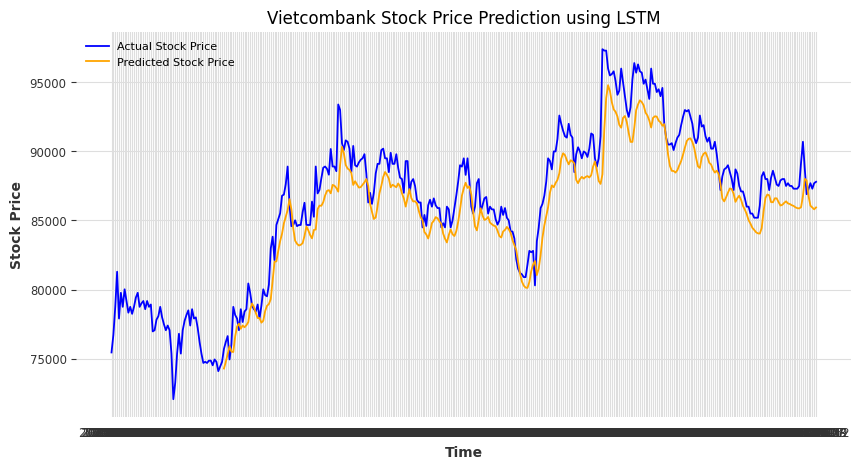

In [43]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
plt.plot(test_data.index, test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:].index, lstm_y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('Vietcombank Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
y_true = test_data[60:]['Close'].values
from sklearn.metrics import mean_absolute_error,\
                            mean_squared_error,\
                            root_mean_squared_error,\
                            mean_absolute_percentage_error
# report performance
mse = mean_squared_error(y_true, lstm_y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, lstm_y_pred)
print('MAE: '+str(mae))
rmse = root_mean_squared_error(y_true, lstm_y_pred)
print('RMSE: '+str(rmse))
mape = mean_absolute_percentage_error(y_true, lstm_y_pred) * 100

print('MAPE: '+str(mape) + "%")

MSE: 4007305.886879521
MAE: 1672.9930747239748
RMSE: 2001.8256384809144
MAPE: 1.8824416376645379%
